In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
from pathlib import Path

BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data" / "database"

print("DATA_DIR =", DATA_DIR)

# Données d'entraînement (Nouvelle-Aquitaine)
df_naq = pd.read_parquet(DATA_DIR / "df_naq.parquet")

# Données France entière, on filtre Grand Est
df_fr = pd.read_parquet(DATA_DIR / "swi_filtre_concat_geo_clean.parquet")
# Sélection du Grand Est (code INSEE 44)
df_ge = df_fr[df_fr["REGION"].astype(str) == "44"].copy()
print("Grand Est :", df_ge.shape)

print("NAQ :", df_naq.shape)


DATA_DIR = /Users/larbi/Documents/PROJET-ML-FOR-CLIMATE-RISK/data/database
Grand Est : (6523365, 17)
NAQ : (9679125, 17)


In [ ]:


def add_swi_lag1(df):
    df = df.copy()
    
    # 1) S'assurer que la date est bien en datetime
    df["DATE"] = pd.to_datetime(df["DATE"])
    
    # 2) Créer un identifiant de maille spatiale si absent
    #    (un id unique par couple (LAMBX, LAMBY))
    if "cell_id" not in df.columns:
        df["cell_id"] = df.groupby(["LAMBX", "LAMBY"]).ngroup()
    
    # 3) Trier par maille puis par date
    df = df.sort_values(["cell_id", "DATE"])
    
    # 4) Calcul du lag : SWI à J-1 par maille
    df["SWI_lag1"] = df.groupby("cell_id")["SWI"].shift(1)
    
    return df

# Application à chaque région
df_naq = add_swi_lag1(df_naq)
df_ge  = add_swi_lag1(df_ge)

print("SWI_lag1 NAQ présent ?", "SWI_lag1" in df_naq.columns)
print("SWI_lag1 GE présent  ?", "SWI_lag1" in df_ge.columns)

# petit check visuel
df_naq[["cell_id", "DATE", "SWI", "SWI_lag1"]].head(10)


SWI_lag1 NAQ présent ? True
SWI_lag1 GE présent  ? True


,cell_id,DATE,SWI,SWI_lag1
0,0,1970-01-01 00:00:00.020000101,1.018,NaN
1,0,1970-01-01 00:00:00.020000102,1.009,1.018
2,0,1970-01-01 00:00:00.020000103,0.994,1.009
3,0,1970-01-01 00:00:00.020000104,0.979,0.994
4,0,1970-01-01 00:00:00.020000105,0.968,0.979
5,0,1970-01-01 00:00:00.020000106,0.956,0.968
6,0,1970-01-01 00:00:00.020000107,0.944,0.956
7,0,1970-01-01 00:00:00.020000108,0.934,0.944
8,0,1970-01-01 00:00:00.020000109,0.940,0.934
9,0,1970-01-01 00:00:00.020000110,0.944,0.940


In [4]:
features = [
    "SWI_lag1",
    "PRENEI", "PRELIQ", "T", "FF",
    "NIVEAU", "dist_argiles_m",
    "LAMBX", "LAMBY",
]

def make_model_df(df, features):
    """Nettoie le DF et renvoie (df_model, X, y)."""
    feats = [f for f in features if f in df.columns]
    df_model = df.dropna(subset=["SWI", "SWI_lag1"] + feats).copy()
    X = df_model[feats]
    y = df_model["SWI"]
    return df_model, X, y

df_model_naq, X_naq, y_naq = make_model_df(df_naq, features)
df_model_ge,  X_ge,  y_ge  = make_model_df(df_ge,  features)

print("NAQ modèle :", df_model_naq.shape)
print("GE  modèle :", df_model_ge.shape)


NAQ modèle : (3418272, 19)
GE  modèle : (1818696, 19)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# =====================================================
# 0) Sous-échantillonnage NAQ pour l'entraînement
# =====================================================
# On ne prend pas les 2,7 millions de lignes pour entraîner,
# mais un échantillon représentatif : 300k train + 100k cal.
n_train = 800_000
n_cal = 200_000
n_total = n_train + n_cal

if len(X_naq) > n_total:
    rng = np.random.RandomState(0)
    idx = rng.choice(X_naq.index, size=n_total, replace=False)
    X_sub = X_naq.loc[idx]
    y_sub = y_naq.loc[idx]
else:
    # Si on a moins de lignes que prévu, on prend tout
    X_sub = X_naq
    y_sub = y_naq
    n_total = len(X_sub)
    n_cal = int(0.25 * n_total)  # 25% pour la calibration

test_size = n_cal / n_total

X_train, X_cal, y_train, y_cal = train_test_split(
    X_sub, y_sub,
    test_size=test_size,
    random_state=0
)

print("Train NAQ (sub) :", X_train.shape)
print("Cal   NAQ (sub) :", X_cal.shape)

# =====================================================
# 1) Random Forest NAQ (version 'light')
# =====================================================
rf = RandomForestRegressor(
    n_estimators=100,   
    max_depth=15,       # profondeur limitée
    max_samples=0.5,    # chaque arbre voit 50% du train
    n_jobs=-1,
    random_state=0,
)
rf.fit(X_train, y_train)

print("Random Forest NAQ (light) entraîné.")

# =====================================================
# 2) Modèles de quantiles pour CQR (5% / 95%)
# =====================================================
alpha_low = 0.05
alpha_high = 0.95

gbr_low = GradientBoostingRegressor(
    loss="quantile",
    alpha=alpha_low,
    n_estimators=150,   # 150 itérations
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,      # stochastic gradient boosting
    random_state=0,
)

gbr_high = GradientBoostingRegressor(
    loss="quantile",
    alpha=alpha_high,
    n_estimators=150,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    random_state=0,
)

gbr_low.fit(X_train, y_train)
gbr_high.fit(X_train, y_train)

print("Modèles de quantiles NAQ (light) entraînés.")

# =====================================================
# 3) Calibration conformale sur NAQ (CQR)
# =====================================================
q_low_cal  = gbr_low.predict(X_cal)
q_high_cal = gbr_high.predict(X_cal)

# scores de non-conformité
scores = np.maximum(q_low_cal - y_cal, y_cal - q_high_cal)

alpha = 0.10  # niveau de risque 10% → intervalle 90%
n_cal = len(scores)
q_hat = np.quantile(
    scores,
    q=np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
)

print(f"q_hat (NAQ) = {q_hat:.4f}")


Train NAQ (sub) : (800000, 9)
Cal   NAQ (sub) : (200000, 9)
Random Forest NAQ (light) entraîné.
Modèles de quantiles NAQ (light) entraînés.
q_hat (NAQ) = -0.0030


In [6]:
# =============================
#  Transfert sur Grand Est
# =============================

# 1) Prédictions ponctuelles (Random Forest NAQ → GE)
y_pred_rf_ge = rf.predict(X_ge)

r2_ge = r2_score(y_ge, y_pred_rf_ge)
rmse_ge = np.sqrt(mean_squared_error(y_ge, y_pred_rf_ge))

print("\n=== Transfert RF NAQ -> Grand Est ===")
print(f"R²   (GE) : {r2_ge:.3f}")
print(f"RMSE (GE) : {rmse_ge:.3f}")

# 2) Intervalles CQR (modèles NAQ + q_hat NAQ, appliqués à GE)
q_low_ge  = gbr_low.predict(X_ge)
q_high_ge = gbr_high.predict(X_ge)

L_cqr_ge = q_low_ge  - q_hat
U_cqr_ge = q_high_ge + q_hat

# Milieu de l'intervalle
y_pred_cqr_ge = 0.5 * (L_cqr_ge + U_cqr_ge)

# Couverture sur Grand Est
covered_ge = (y_ge >= L_cqr_ge) & (y_ge <= U_cqr_ge)
coverage_empirical_ge = covered_ge.mean()
width_mean_ge = (U_cqr_ge - L_cqr_ge).mean()

r2_cqr_ge = r2_score(y_ge, y_pred_cqr_ge)
rmse_cqr_ge = np.sqrt(mean_squared_error(y_ge, y_pred_cqr_ge))

print("\n=== Conformal Prediction (CQR) – NAQ calibré, évalué sur Grand Est ===")
print(f"Couverture empirique (GE) : {coverage_empirical_ge*100:.2f} %")
print(f"Largeur moyenne (GE)      : {width_mean_ge:.4f}")
print(f"R² (centre CQR, GE)       : {r2_cqr_ge:.3f}")
print(f"RMSE (centre CQR, GE)     : {rmse_cqr_ge:.3f}")



=== Transfert RF NAQ -> Grand Est ===
R²   (GE) : 0.997
RMSE (GE) : 0.015

=== Conformal Prediction (CQR) – NAQ calibré, évalué sur Grand Est ===
Couverture empirique (GE) : 92.89 %
Largeur moyenne (GE)      : 0.1810
R² (centre CQR, GE)       : 0.838
RMSE (centre CQR, GE)     : 0.106


In [7]:
# On reconstruit un df_test_full_GE avec toutes les colonnes d'origine
df_ge_results = df_model_ge.loc[X_ge.index].copy()

df_ge_results["y_true"]      = y_ge.values
df_ge_results["y_pred_rf"]   = y_pred_rf_ge
df_ge_results["y_pred_cqr"]  = y_pred_cqr_ge
df_ge_results["L_cqr"]       = L_cqr_ge
df_ge_results["U_cqr"]       = U_cqr_ge
df_ge_results["covered_cqr"] = covered_ge.astype(int)

# pour les cartes / stats
df_ge_results["width_cqr"]   = df_ge_results["U_cqr"] - df_ge_results["L_cqr"]

df_ge_results.head()


,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,SWI,SSWI_10J,ALEA,...,REGION,cell_id,SWI_lag1,y_true,y_pred_rf,y_pred_cqr,L_cqr,U_cqr,covered_cqr,width_cqr
976795,7000,23690,1970-01-01 00:00:00.020000102,0.0,0.0,6.1,0.5,1.052,1.884,Moyen,...,44,6,1.065,1.052,1.049070,0.852353,0.646142,1.058564,1,0.412422
976796,7000,23690,1970-01-01 00:00:00.020000103,0.0,0.4,4.8,2.5,1.035,1.904,Moyen,...,44,6,1.052,1.035,1.044664,0.851954,0.646142,1.057765,1,0.411623
976797,7000,23690,1970-01-01 00:00:00.020000104,0.0,6.6,7.3,3.8,1.032,1.885,Moyen,...,44,6,1.035,1.032,1.048432,0.862479,0.646142,1.078817,1,0.432675
976798,7000,23690,1970-01-01 00:00:00.020000105,0.0,0.1,7.0,1.7,1.028,1.822,Moyen,...,44,6,1.032,1.028,1.021933,0.838944,0.646142,1.031746,1,0.385605
976799,7000,23690,1970-01-01 00:00:00.020000106,0.0,2.6,6.6,2.3,1.015,1.723,Moyen,...,44,6,1.028,1.015,1.027981,0.851016,0.646142,1.055889,1,0.409747


In [8]:
import geopandas as gpd

gdf_ge = gpd.GeoDataFrame(
    df_ge_results.copy(),
    geometry=gpd.points_from_xy(df_ge_results["LAMBX"], df_ge_results["LAMBY"]),
    crs="EPSG:2154"   # Lambert-93
)

gdf_ge.head()


,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,SWI,SSWI_10J,ALEA,...,cell_id,SWI_lag1,y_true,y_pred_rf,y_pred_cqr,L_cqr,U_cqr,covered_cqr,width_cqr,geometry
976795,7000,23690,1970-01-01 00:00:00.020000102,0.0,0.0,6.1,0.5,1.052,1.884,Moyen,...,6,1.065,1.052,1.049070,0.852353,0.646142,1.058564,1,0.412422,POINT (7000 23690)
976796,7000,23690,1970-01-01 00:00:00.020000103,0.0,0.4,4.8,2.5,1.035,1.904,Moyen,...,6,1.052,1.035,1.044664,0.851954,0.646142,1.057765,1,0.411623,POINT (7000 23690)
976797,7000,23690,1970-01-01 00:00:00.020000104,0.0,6.6,7.3,3.8,1.032,1.885,Moyen,...,6,1.035,1.032,1.048432,0.862479,0.646142,1.078817,1,0.432675,POINT (7000 23690)
976798,7000,23690,1970-01-01 00:00:00.020000105,0.0,0.1,7.0,1.7,1.028,1.822,Moyen,...,6,1.032,1.028,1.021933,0.838944,0.646142,1.031746,1,0.385605,POINT (7000 23690)
976799,7000,23690,1970-01-01 00:00:00.020000106,0.0,2.6,6.6,2.3,1.015,1.723,Moyen,...,6,1.028,1.015,1.027981,0.851016,0.646142,1.055889,1,0.409747,POINT (7000 23690)


In [ ]:
import numpy as np

# 1) Prédictions RF sur le Grand Est
y_pred_rf_ge = rf.predict(X_ge)

# 2) DataFrame de résultats complet pour GE
df_ge_results = df_model_ge.loc[X_ge.index].copy()

df_ge_results["y_true"]    = y_ge.values          # SWI observé
df_ge_results["y_pred_rf"] = y_pred_rf_ge         # SWI prédit (RF)

# 3) Erreurs
df_ge_results["error"]     = df_ge_results["y_pred_rf"] - df_ge_results["y_true"]
df_ge_results["error_abs"] = df_ge_results["error"].abs()

print("Colonnes df_ge_results :")
print(df_ge_results.columns.tolist())
df_ge_results[["y_true", "y_pred_rf", "error", "error_abs"]].head()


Colonnes df_ge_results :
['LAMBX', 'LAMBY', 'DATE', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SWI', 'SSWI_10J', 'ALEA', 'NIVEAU', 'DPT', 'ARGILES_FROM', 'dist_argiles_m', 'COMMUNE', 'DEPARTEMENT', 'REGION', 'cell_id', 'SWI_lag1', 'y_true', 'y_pred_rf', 'error', 'error_abs']


,y_true,y_pred_rf,error,error_abs
976795,1.052,1.049070,-0.002930,0.002930
976796,1.035,1.044664,0.009664,0.009664
976797,1.032,1.048432,0.016432,0.016432
976798,1.028,1.021933,-0.006067,0.006067
976799,1.015,1.027981,0.012981,0.012981


In [ ]:

gdf_ge = gpd.GeoDataFrame(
    df_ge_results.copy(),
    geometry=gpd.points_from_xy(df_ge_results["LAMBX"], df_ge_results["LAMBY"]),
    crs="EPSG:2154"   # Lambert-93
)

print("Colonnes gdf_ge :")
print(gdf_ge.columns.tolist())
gdf_ge.head()


Colonnes gdf_ge :
['LAMBX', 'LAMBY', 'DATE', 'PRENEI', 'PRELIQ', 'T', 'FF', 'SWI', 'SSWI_10J', 'ALEA', 'NIVEAU', 'DPT', 'ARGILES_FROM', 'dist_argiles_m', 'COMMUNE', 'DEPARTEMENT', 'REGION', 'cell_id', 'SWI_lag1', 'y_true', 'y_pred_rf', 'error', 'error_abs', 'geometry']


,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,SWI,SSWI_10J,ALEA,...,COMMUNE,DEPARTEMENT,REGION,cell_id,SWI_lag1,y_true,y_pred_rf,error,error_abs,geometry
976795,7000,23690,1970-01-01 00:00:00.020000102,0.0,0.0,6.1,0.5,1.052,1.884,Moyen,...,Pouy-sur-Vannes,10,44,6,1.065,1.052,1.049070,-0.002930,0.002930,POINT (7000 23690)
976796,7000,23690,1970-01-01 00:00:00.020000103,0.0,0.4,4.8,2.5,1.035,1.904,Moyen,...,Pouy-sur-Vannes,10,44,6,1.052,1.035,1.044664,0.009664,0.009664,POINT (7000 23690)
976797,7000,23690,1970-01-01 00:00:00.020000104,0.0,6.6,7.3,3.8,1.032,1.885,Moyen,...,Pouy-sur-Vannes,10,44,6,1.035,1.032,1.048432,0.016432,0.016432,POINT (7000 23690)
976798,7000,23690,1970-01-01 00:00:00.020000105,0.0,0.1,7.0,1.7,1.028,1.822,Moyen,...,Pouy-sur-Vannes,10,44,6,1.032,1.028,1.021933,-0.006067,0.006067,POINT (7000 23690)
976799,7000,23690,1970-01-01 00:00:00.020000106,0.0,2.6,6.6,2.3,1.015,1.723,Moyen,...,Pouy-sur-Vannes,10,44,6,1.028,1.015,1.027981,0.012981,0.012981,POINT (7000 23690)


In [11]:
gdf_cells_ge = (
    gdf_ge
    .groupby("cell_id")
    .agg(
        swi_true_mean   = ("y_true", "mean"),
        swi_pred_mean   = ("y_pred_rf", "mean"),
        error_mean      = ("error", "mean"),
        error_abs_mean  = ("error_abs", "mean"),
        DEPARTEMENT     = ("DEPARTEMENT", "first"),
        geometry        = ("geometry", "first"),
    )
    .reset_index()
)

gdf_cells_ge = gpd.GeoDataFrame(gdf_cells_ge, geometry="geometry", crs=gdf_ge.crs)
gdf_cells_ge.head()


,cell_id,swi_true_mean,swi_pred_mean,error_mean,error_abs_mean,DEPARTEMENT,geometry
0,6,0.647920,0.649074,0.001154,0.007555,10,POINT (7000 23690)
1,19,0.564039,0.566383,0.002344,0.007382,10,POINT (7080 23850)
2,21,0.569845,0.572254,0.002409,0.008275,51,POINT (7080 24010)
3,24,0.596981,0.599192,0.002211,0.008160,51,POINT (7080 24250)
4,33,0.649553,0.650625,0.001072,0.007236,10,POINT (7160 23690)


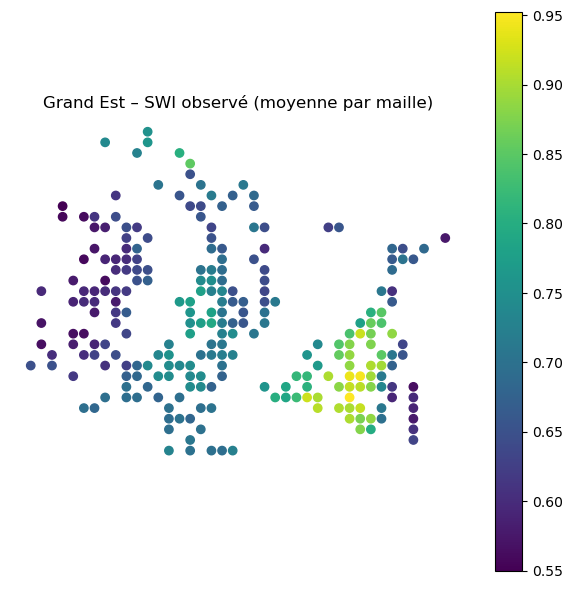

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells_ge.plot(
    column="swi_true_mean",
    ax=ax,
    legend=True,
)
ax.set_title("Grand Est – SWI observé (moyenne par maille)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


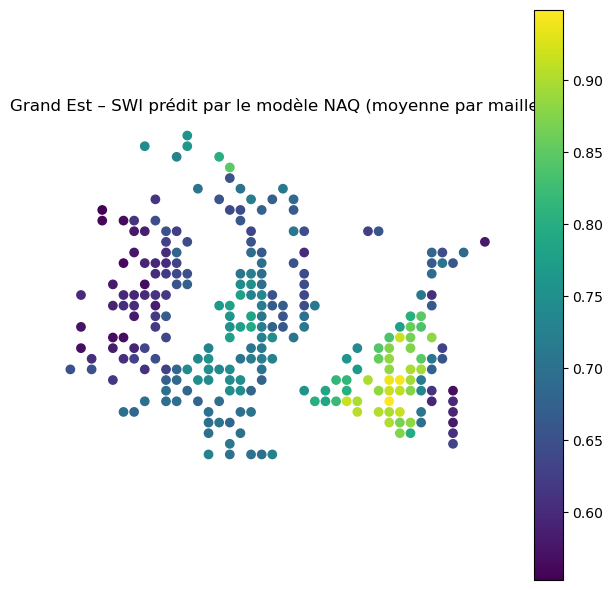

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells_ge.plot(
    column="swi_pred_mean",
    ax=ax,
    legend=True,
)
ax.set_title("Grand Est – SWI prédit par le modèle NAQ (moyenne par maille)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


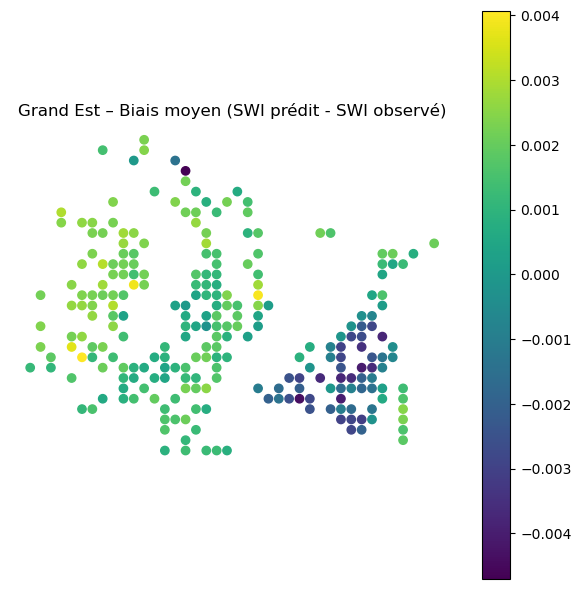

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells_ge.plot(
    column="error_mean",
    ax=ax,
    legend=True,
)
ax.set_title("Grand Est – Biais moyen (SWI prédit - SWI observé)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


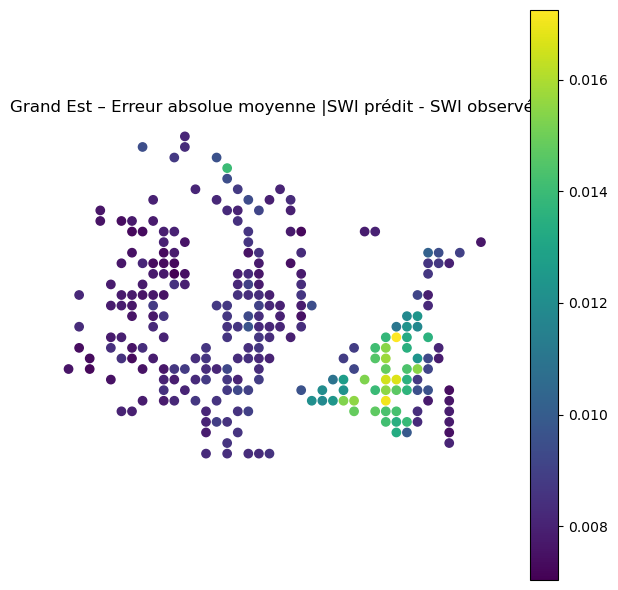

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf_cells_ge.plot(
    column="error_abs_mean",
    ax=ax,
    legend=True,
)
ax.set_title("Grand Est – Erreur absolue moyenne |SWI prédit - SWI observé|")
ax.set_axis_off()
plt.tight_layout()
plt.show()


/var/folders/l2/3qbz1vkx3bq06k8qhcsn4k340000gp/T/ipykernel_17232/3787714969.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/larbi/miniconda3/envs/climaterisk/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


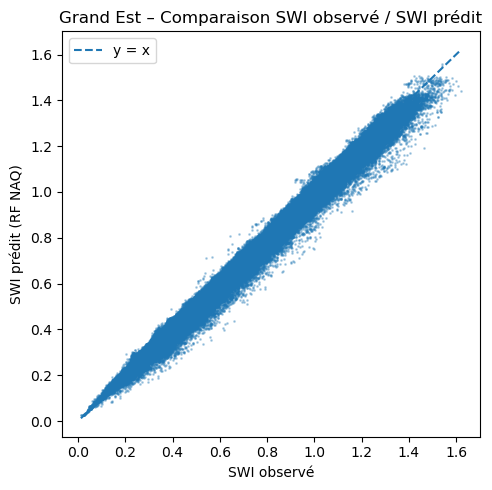

In [16]:
plt.figure(figsize=(5, 5))
plt.scatter(
    df_ge_results["y_true"],
    df_ge_results["y_pred_rf"],
    s=1, alpha=0.3
)
min_val = min(df_ge_results["y_true"].min(), df_ge_results["y_pred_rf"].min())
max_val = max(df_ge_results["y_true"].max(), df_ge_results["y_pred_rf"].max())
plt.plot([min_val, max_val], [min_val, max_val], "--", label="y = x")

plt.xlabel("SWI observé")
plt.ylabel("SWI prédit (RF NAQ)")
plt.title("Grand Est – Comparaison SWI observé / SWI prédit")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
%pip install gstools

Note: you may need to restart the kernel to use updated packages.


In [18]:
# gdf_ge : point-level Grand Est avec SWI
# gdf_cells_ge : moyennes par maille (cell_id), déjà calculées

gdf_cells_ge.head()
# colonnes attendues : ['cell_id', 'swi_true_mean', 'geometry', ...]


,cell_id,swi_true_mean,swi_pred_mean,error_mean,error_abs_mean,DEPARTEMENT,geometry
0,6,0.647920,0.649074,0.001154,0.007555,10,POINT (7000 23690)
1,19,0.564039,0.566383,0.002344,0.007382,10,POINT (7080 23850)
2,21,0.569845,0.572254,0.002409,0.008275,51,POINT (7080 24010)
3,24,0.596981,0.599192,0.002211,0.008160,51,POINT (7080 24250)
4,33,0.649553,0.650625,0.001072,0.007236,10,POINT (7160 23690)


In [19]:
from sklearn.model_selection import train_test_split

train_ge, test_ge = train_test_split(
    gdf_cells_ge,
    test_size=0.2,
    random_state=0,
)

print("Train GE :", train_ge.shape)
print("Test  GE :", test_ge.shape)


Train GE : (199, 7)
Test  GE : (50, 7)


In [ ]:
import numpy as np
import gstools as gs
from sklearn.metrics import r2_score, mean_squared_error

# ====== Données spatiales Grand Est (train) ======
x_train = train_ge.geometry.x.values
y_train = train_ge.geometry.y.values
z_train = train_ge["swi_true_mean"].values

# Empirical variogram sur Grand Est (bins par défaut)
bins, gamma = gs.vario_estimate_unstructured(
    (x_train, y_train),
    z_train,
)

# Modèle de variogramme (Exponential, comme en Partie II par ex.)
model_ge = gs.Exponential(dim=2)  # ou gs.Spherical(dim=2), gs.Matern...

# Ajustement des paramètres du variogramme aux données GE
model_ge.fit_variogram(bins, gamma)

print(model_ge)  

# Kriging ordinaire recalibré sur GE
ok_ge = gs.krige.Ordinary(
    model_ge,
    cond_pos=(x_train, y_train),
    cond_val=z_train,
)

# ====== Évaluation sur le test ======
x_test = test_ge.geometry.x.values
y_test = test_ge.geometry.y.values
z_test_true = test_ge["swi_true_mean"].values

z_test_pred, var_test = ok_ge((x_test, y_test), return_var=True)

r2_ge_krig = r2_score(z_test_true, z_test_pred)
rmse_ge_krig = np.sqrt(mean_squared_error(z_test_true, z_test_pred))

print(f"Kriging recalibré Grand Est – R²  : {r2_ge_krig:.3f}")
print(f"Kriging recalibré Grand Est – RMSE: {rmse_ge_krig:.3f}")


Exponential(dim=2, var=0.0118, len_scale=8.21e+02, nugget=3.17e-06)
Kriging recalibré Grand Est – R²  : 0.855
Kriging recalibré Grand Est – RMSE: 0.033


In [21]:
# Coordonnées + valeurs observées sur le test
x_test = test_ge.geometry.x.values
y_test = test_ge.geometry.y.values
z_test_true = test_ge["swi_true_mean"].values

# Prédiction krigée sur les mailles test
z_test_pred, var_test = ok_ge(
    (x_test, y_test),
    return_var=True
)

r2_ge_krig = r2_score(z_test_true, z_test_pred)
rmse_ge_krig = np.sqrt(mean_squared_error(z_test_true, z_test_pred))

print(f"Kriging recalibré Grand Est – R²  : {r2_ge_krig:.3f}")
print(f"Kriging recalibré Grand Est – RMSE: {rmse_ge_krig:.3f}")


Kriging recalibré Grand Est – R²  : 0.855
Kriging recalibré Grand Est – RMSE: 0.033


In [22]:
test_ge["swi_krig_pred"] = z_test_pred
test_ge["swi_krig_var"]  = var_test

## 4. Adaptation et recalibrage
### 4.1 Réentraînement local des modèles IA (Binôme 1)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# --- 4.1.0 Petite fonction de sous-échantillonnage pour ne pas exploser le temps de calcul
def subsample_xy(X, y, n_max=200_000, random_state=0):
    """
    Retourne (X_sub, y_sub) en sous-échantillonnant si besoin.
    """
    if len(X) > n_max:
        rnd = np.random.RandomState(random_state)
        idx = rnd.choice(len(X), size=n_max, replace=False)
        return X.iloc[idx], y.iloc[idx]
    return X, y

# On part des X_naq, y_naq, X_ge, y_ge déjà créés plus haut dans par3.ipynb
X_naq_sub, y_naq_sub = subsample_xy(X_naq, y_naq, n_max=200_000, random_state=0)
X_ge_sub,  y_ge_sub  = subsample_xy(X_ge,  y_ge,  n_max=200_000, random_state=1)

print("Taille NAQ utilisée :", X_naq_sub.shape)
print("Taille GE utilisée  :", X_ge_sub.shape)


def train_eval_rf(X, y, test_size=0.2, random_state=0, label=""):
    """
    Entraîne un RF sur (X,y) et affiche R² / RMSE sur un test hold-out.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        n_jobs=-1,
        random_state=0,
    )
    rf.fit(X_tr, y_tr)

    y_pred = rf.predict(X_te)
    r2   = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))

    print(f"[{label}] R²  = {r2:.3f}   RMSE = {rmse:.3f}")
    return rf, X_te, y_te, y_pred

Taille NAQ utilisée : (200000, 9)
Taille GE utilisée  : (200000, 9)


In [26]:
# ---- Scénario A : modèle global NAQ (référence)
rf_naq_loc, X_te_naq_loc, y_te_naq_loc, y_pred_naq_loc = train_eval_rf(
    X_naq_sub, y_naq_sub, label="RF NAQ (global)"
)

# ---- Scénario B : modèle local Grand Est
rf_ge_loc, X_te_ge_loc, y_te_ge_loc, y_pred_ge_loc = train_eval_rf(
    X_ge_sub, y_ge_sub, label="RF GE (local)"
)

# ---- Scénario C : modèle mixte NAQ+GE avec pondération en faveur du Grand Est
X_mix = pd.concat([X_naq_sub, X_ge_sub], axis=0)
y_mix = pd.concat([y_naq_sub, y_ge_sub], axis=0)

weights = np.concatenate([
    np.ones(len(X_naq_sub)),        # poids 1 pour NAQ
    np.full(len(X_ge_sub), 3.0),    # poids 3 pour GE (on privilégie la région cible)
])

X_tr_mix, X_te_mix, y_tr_mix, y_te_mix, w_tr_mix, w_te_mix = train_test_split(
    X_mix, y_mix, weights,
    test_size=0.2,
    random_state=0,
)

# 👉 on n'utilise PAS train_eval_rf ici
rf_mix = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    n_jobs=-1,
    random_state=0,
)
rf_mix.fit(X_tr_mix, y_tr_mix, sample_weight=w_tr_mix)

y_pred_mix = rf_mix.predict(X_te_mix)
r2_mix   = r2_score(y_te_mix, y_pred_mix)
rmse_mix = np.sqrt(mean_squared_error(y_te_mix, y_pred_mix))

print(f"[RF mixte NAQ+GE] R² = {r2_mix:.3f}   RMSE = {rmse_mix:.3f}")


[RF NAQ (global)] R²  = 0.997   RMSE = 0.016
[RF GE (local)] R²  = 0.997   RMSE = 0.014
[RF mixte NAQ+GE] R² = 0.997   RMSE = 0.015


## Sans SWI lag 1

Analyse sans terme auto-régressif

Taille NAQ sans lag : (200000, 8)
Taille GE  sans lag : (200000, 8)
[RF NAQ sans SWI_lag1] R²  = 0.521   RMSE = 0.196
[RF GE sans SWI_lag1] R²  = 0.535   RMSE = 0.179
[RF mixte NAQ+GE sans SWI_lag1] R² = 0.537   RMSE = 0.187


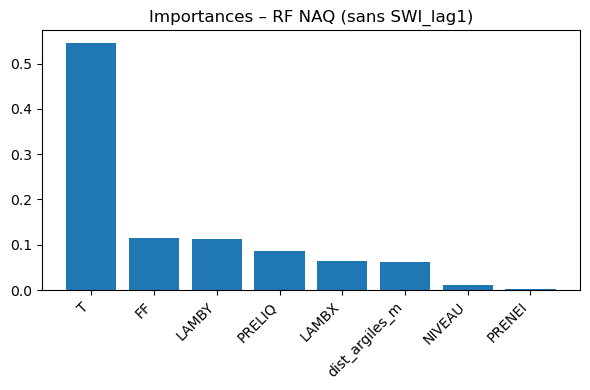

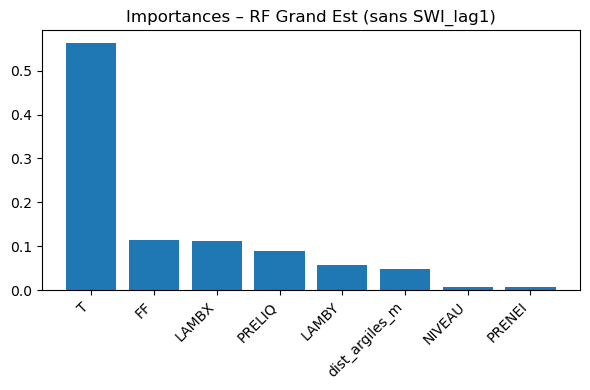

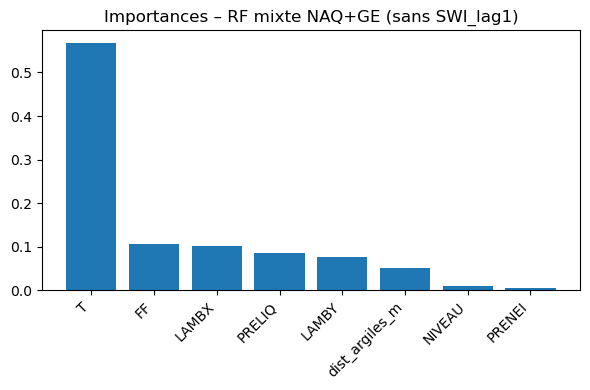

In [31]:
# ============================================================
# 4.1 bis – Même analyse, mais SANS SWI_lag1
# ============================================================

# 1) On enlève SWI_lag1 des features
X_naq_nolag = X_naq.drop(columns=["SWI_lag1"])
X_ge_nolag  = X_ge.drop(columns=["SWI_lag1"])

# 2) Sous-échantillonnage pour que ça tourne vite
X_naq_sub_nolag, y_naq_sub_nolag = subsample_xy(
    X_naq_nolag, y_naq, n_max=200_000, random_state=0
)
X_ge_sub_nolag, y_ge_sub_nolag = subsample_xy(
    X_ge_nolag,  y_ge,  n_max=200_000, random_state=1
)

print("Taille NAQ sans lag :", X_naq_sub_nolag.shape)
print("Taille GE  sans lag :", X_ge_sub_nolag.shape)

# 3) RF NAQ sans SWI_lag1
rf_naq_nolag, X_te_naq_nolag, y_te_naq_nolag, y_pred_naq_nolag = train_eval_rf(
    X_naq_sub_nolag,
    y_naq_sub_nolag,
    label="RF NAQ sans SWI_lag1"
)

# 4) RF Grand Est sans SWI_lag1
rf_ge_nolag, X_te_ge_nolag, y_te_ge_nolag, y_pred_ge_nolag = train_eval_rf(
    X_ge_sub_nolag,
    y_ge_sub_nolag,
    label="RF GE sans SWI_lag1"
)

# 5) RF mixte NAQ+GE sans SWI_lag1 (avec pondération pour le GE)
X_mix_nolag = pd.concat([X_naq_sub_nolag, X_ge_sub_nolag], axis=0)
y_mix_nolag = pd.concat([y_naq_sub_nolag, y_ge_sub_nolag], axis=0)

weights_nolag = np.concatenate([
    np.ones(len(X_naq_sub_nolag)),         # poids 1 pour NAQ
    np.full(len(X_ge_sub_nolag), 3.0),     # poids 3 pour GE
])

X_tr_mix_nolag, X_te_mix_nolag, y_tr_mix_nolag, y_te_mix_nolag, w_tr_mix_nolag, w_te_mix_nolag = train_test_split(
    X_mix_nolag,
    y_mix_nolag,
    weights_nolag,
    test_size=0.2,
    random_state=0,
)

rf_mix_nolag = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    n_jobs=-1,
    random_state=0,
)
rf_mix_nolag.fit(X_tr_mix_nolag, y_tr_mix_nolag, sample_weight=w_tr_mix_nolag)

y_pred_mix_nolag = rf_mix_nolag.predict(X_te_mix_nolag)
r2_mix_nolag   = r2_score(y_te_mix_nolag, y_pred_mix_nolag)
rmse_mix_nolag = np.sqrt(mean_squared_error(y_te_mix_nolag, y_pred_mix_nolag))

print(f"[RF mixte NAQ+GE sans SWI_lag1] R² = {r2_mix_nolag:.3f}   RMSE = {rmse_mix_nolag:.3f}")

# 6) Importances des variables (sans lag)
plot_feature_importances(rf_naq_nolag, X_naq_sub_nolag, "Importances – RF NAQ (sans SWI_lag1)")
plot_feature_importances(rf_ge_nolag,  X_ge_sub_nolag,  "Importances – RF Grand Est (sans SWI_lag1)")
plot_feature_importances(rf_mix_nolag, X_mix_nolag,     "Importances – RF mixte NAQ+GE (sans SWI_lag1)")


### 4.2 Recalibrage des modèles géostatistiques (Binôme 2)


In [ ]:
# ============================================================
# 4.2 Binôme 2 : Recalibrage des modèles géostatistiques (Kriging)
# ============================================================

import gstools as gs
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np



x_train = train_ge.geometry.x.values
y_train = train_ge.geometry.y.values
z_train = train_ge["swi_true_mean"].values

# Variogramme empirique local Grand Est
bins, gamma = gs.vario_estimate_unstructured(
    (x_train, y_train),
    z_train,
)

model_ge = gs.Exponential(dim=2)   # même famille que le variogramme utilisé en Partie II
model_ge.fit_variogram(bins, gamma)

print(model_ge)    # range, sill, nugget recalibrés sur le Grand Est

# Kriging ordinaire recalibré
ok_ge = gs.krige.Ordinary(
    model_ge,
    cond_pos=(x_train, y_train),
    cond_val=z_train,
)

# Évaluation sur les mailles test
x_test = test_ge.geometry.x.values
y_test = test_ge.geometry.y.values
z_test_true = test_ge["swi_true_mean"].values

z_test_pred, var_test = ok_ge((x_test, y_test), return_var=True)

r2_ge_krig = r2_score(z_test_true, z_test_pred)
rmse_ge_krig = np.sqrt(mean_squared_error(z_test_true, z_test_pred))

print(f"Kriging recalibré Grand Est – R²  : {r2_ge_krig:.3f}")
print(f"Kriging recalibré Grand Est – RMSE: {rmse_ge_krig:.3f}")

# On stocke les résultats pour les cartes "avant / après" plus tard
test_ge["swi_krig_pred"] = z_test_pred
test_ge["swi_krig_var"]  = var_test


Exponential(dim=2, var=0.0118, len_scale=8.21e+02, nugget=3.17e-06)
Kriging recalibré Grand Est – R²  : 0.855
Kriging recalibré Grand Est – RMSE: 0.033
